# M3 - Assignment 1 📨
## MICROSTRATEGY STOCK - MSTR 📈
Stock price prediction

In [6]:
# import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('MSTR', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

[*********************100%***********************]  1 of 1 completed


In [12]:
df.head(15)

Price,Close,lag_5,rolling_mean_10,rolling_sd_10
Ticker,MSTR,,,
Date,,,,
2020-02-24,14.588,14.884,14.9350,0.178517
2020-02-25,14.005,14.797,14.8210,0.329588
2020-02-26,14.012,14.960,14.7012,0.385471
2020-02-27,13.622,14.980,14.5650,0.498496
2020-02-28,13.516,14.995,14.4359,0.587996
2020-03-02,13.672,14.588,14.3147,0.609873
2020-03-03,13.439,14.005,14.1789,0.640948
2020-03-04,13.617,14.012,14.0446,0.598385


In [8]:
# Check if there are any missing values in the DataFrame
has_missing_values = df.isna().any().any()

if has_missing_values:
    print("The DataFrame has missing values.")
else:
    print("The DataFrame has no missing values.")

The DataFrame has no missing values.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50, Train Loss: 0.000264, Valid Loss: 0.001220
Epoch 4/50, Train Loss: 0.000373, Valid Loss: 0.001314
Epoch 6/50, Train Loss: 0.000450, Valid Loss: 0.001372
Epoch 8/50, Train Loss: 0.000489, Valid Loss: 0.001372
Epoch 10/50, Train Loss: 0.000508, Valid Loss: 0.001307
Epoch 12/50, Train Loss: 0.000461, Valid Loss: 0.001187
Epoch 14/50, Train Loss: 0.000414, Valid Loss: 0.001075
Epoch 16/50, Train Loss: 0.000346, Valid Loss: 0.001008
Epoch 18/50, Train Loss: 0.000289, Valid Loss: 0.000955
Epoch 20/50, Train Loss: 0.000257, Valid Loss: 0.000909
Epoch 22/50, Train Loss: 0.000231, Valid Loss: 0.000853
Epoch 24/50, Train Loss: 0.000215, Valid Loss: 0.000785
Epoch 26/50, Train Loss: 0.000197, Valid Loss: 0.000761
Epoch 28/50, Train Loss: 0.000192, Valid Loss: 0.000704
Epoch 30/50, Train Loss: 0.000173, Valid Loss: 0.000642
Epoch 32/50, Train Loss: 0.000167, Valid Loss: 0.000606
Epoch 34/50, Train Loss: 0.000165, Valid Loss: 0.000553
Epoch 36/50, Train Loss: 0.000155, Valid Loss: 0.000

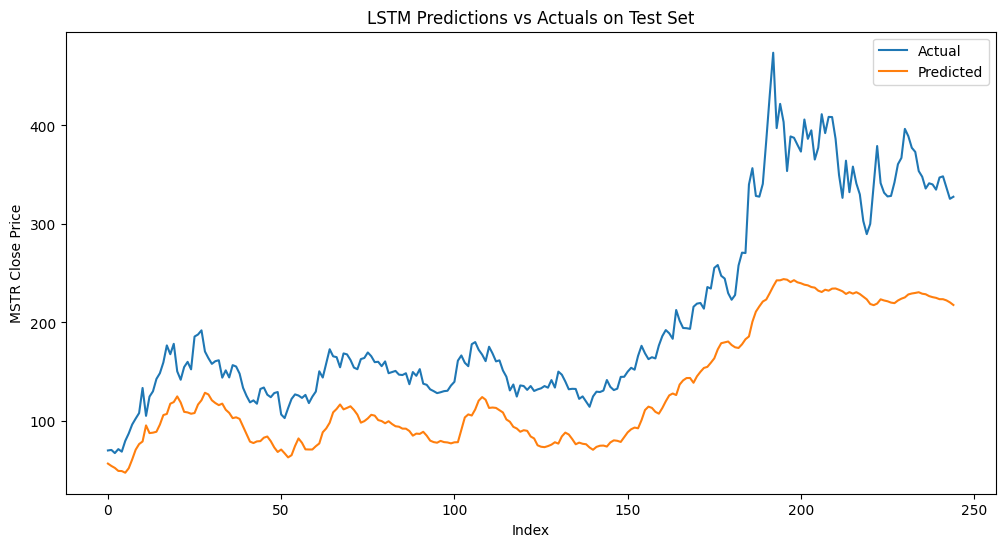


Test Set Metrics:
MAE: 73.07
MSE: 6937.76
RMSE: 83.29
R² Score: 0.26


In [28]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 6: Build the LSTM Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out


# Instantiate the LSTM model
model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1, dropout=0.1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
model.eval()
with torch.no_grad(): # this way prevents PyTorch from storing unnecessary information for backpropagation, making inference faster and more memory-efficient.
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

# Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('MSTR Close Price')
plt.legend()
plt.show()

# calculate metrics
mae = mean_absolute_error(test_actuals_denorm, test_preds_denorm)
mse = mean_squared_error(test_actuals_denorm, test_preds_denorm)
rmse = np.sqrt(mse)
r2 = r2_score(test_actuals_denorm, test_preds_denorm)

print("\nTest Set Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# OTHER HYPER PARAMETERS??

Indication of underfitting? based on the predictions being way lower than the actual
* We need to take into account, that the stock has fluctated alot as well.

* hidden_size = 250 (before: 50)
 - This parameter controls the number of features in the hidden state of the LSTM.
 - We increased this, cause there may be more complex patterns we don't catch yet...
* num_epochs = 100 (before: 50)
 - This is the number of times the model sees the entire training dataset.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Train Loss: 0.000649, Valid Loss: 0.001526
Epoch 4/100, Train Loss: 0.001137, Valid Loss: 0.001486
Epoch 6/100, Train Loss: 0.001076, Valid Loss: 0.001309
Epoch 8/100, Train Loss: 0.001029, Valid Loss: 0.001191
Epoch 10/100, Train Loss: 0.001009, Valid Loss: 0.001123
Epoch 12/100, Train Loss: 0.000917, Valid Loss: 0.001055
Epoch 14/100, Train Loss: 0.000753, Valid Loss: 0.000892
Epoch 16/100, Train Loss: 0.000548, Valid Loss: 0.000642
Epoch 18/100, Train Loss: 0.000335, Valid Loss: 0.000498
Epoch 20/100, Train Loss: 0.000224, Valid Loss: 0.000390
Epoch 22/100, Train Loss: 0.000192, Valid Loss: 0.000378
Epoch 24/100, Train Loss: 0.000179, Valid Loss: 0.000335
Epoch 26/100, Train Loss: 0.000180, Valid Loss: 0.000340
Epoch 28/100, Train Loss: 0.000169, Valid Loss: 0.000317
Epoch 30/100, Train Loss: 0.000162, Valid Loss: 0.000287
Epoch 32/100, Train Loss: 0.000155, Valid Loss: 0.000251
Epoch 34/100, Train Loss: 0.000151, Valid Loss: 0.000273
Epoch 36/100, Train Loss: 0.000151,

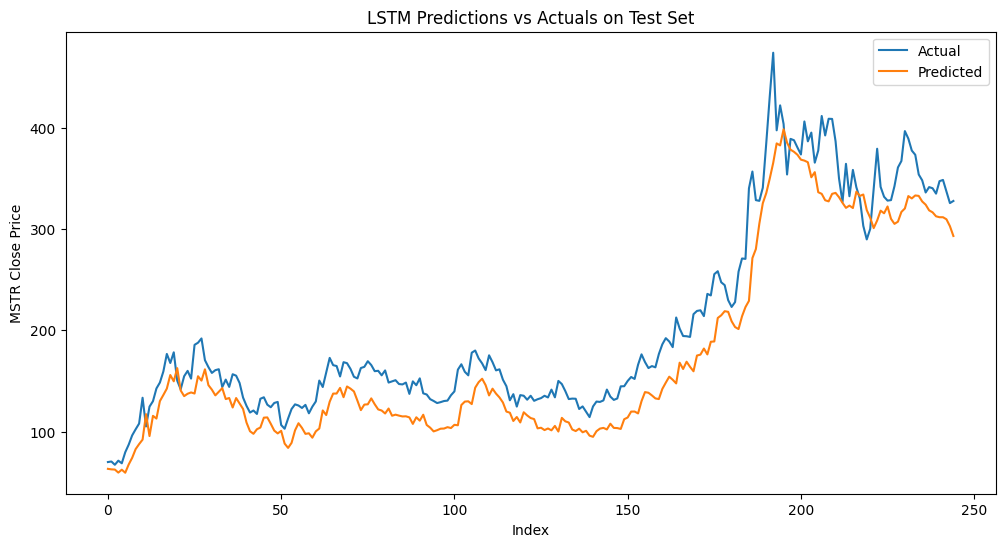


Test Set Metrics:
MAE: 30.13
MSE: 1194.28
RMSE: 34.56
R² Score: 0.87


In [29]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 6: Build the LSTM Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out

# Step 1-5 already done..
# NEW HYPERPARAMETERS:

# Instantiate the LSTM model
model = LSTMModel(
    input_size=n_features,
    hidden_size=250,
    num_layers=2,
    output_size=1,
    dropout=0.2)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 100
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
model.eval()
with torch.no_grad(): # this way prevents PyTorch from storing unnecessary information for backpropagation, making inference faster and more memory-efficient.
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

# Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('MSTR Close Price')
plt.legend()
plt.show()

# calculate metrics
mae = mean_absolute_error(test_actuals_denorm, test_preds_denorm)
mse = mean_squared_error(test_actuals_denorm, test_preds_denorm)
rmse = np.sqrt(mse)
r2 = r2_score(test_actuals_denorm, test_preds_denorm)

print("\nTest Set Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")